In [1]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

from file_manager import FileManager
fm = FileManager()

In [2]:
def matchup_info(**kwargs):
    df: pd.DataFrame = fm.load_clean_data()
    
    
    # team fantasy points
    tm = (df
          .groupby(['date', 'team'])
          ['fpts']
          .agg([np.sum])
         )
    
    msg = 'Adding team fantasy points\n'
    print(msg)
    for idx in tqdm(tm.index):
        date, team = idx
        df.loc[(df['date']==date) & (df['team']==team), 'team_fpts'] = tm.loc[idx,'sum']
    
    
    df['matchup'] = tuple(zip(df['team'], df['opp']))
    df['matchup'] = df['matchup'].map(lambda x: tuple(sorted(x)))
    
    # matchup fantasy points
    mu = (df
          .groupby(['date', 'matchup'])
          ['fpts']
          .agg([np.sum])
          .reset_index()
         )
    
#   Doing it this way because issue with having nested tuple in the index
    matchup_info = {
        date: {
            matchup: (mu
                      .loc[(mu['date']==date)
                           & (mu['matchup']==matchup)
                          ]
                      ['sum']
                      .item()
                     )
            for matchup in mu.loc[mu['date']==date, 'matchup'].drop_duplicates()
        }
        for date in mu['date'].drop_duplicates()
    }
    
    print(msg.replace('team', 'matchup'))
    for date, mu_totals in tqdm(matchup_info.items()):
        for matchup, total in mu_totals.items():
            df.loc[(df['date']==date) & (df['matchup']==matchup), 'mu_fpts'] = total
    
    # Save it for later use --> where just read as csv instead of running function
    fm.save_dataframe(df, 'season-data-matchups')
    
    return None

In [3]:
# matchup_info()

In [4]:
def make_boxplots(**kwargs):
    # Need transpose for all boxplots in one
    
    dfpath: str = '/'.join([fm.data_dir, 'season-data-matchups.csv'])
    
    fpts_cols: list[str,...] = [
        'date',
        'team',
        'opp',
        'team_fpts',
        'mu_fpts'
    ]
    
    
#     starter_: tuple[int,...] = (0,1) if kwargs.get('starter') is None else (int(kwargs['starter']),)
#     starter_msg_part: str = "all"
#     if len(starter_) == 1:
#         starter_msg_part: str = 'starting' if kwargs['starter'] else 'bench'
    
#     starter_msg: str = f'Data includes {starter_msg_part} players{"" if len(starter_)>1 else " only"}.\n'
    
    # print(starter_msg)
    
    df: pd.DataFrame = (pd
                        .read_csv(dfpath)
                        # .pipe(lambda df_: df_.loc[df_['starter'].isin(starter_)])
                        [fpts_cols]
                        .drop_duplicates()
                       )
    
    teams: list[str,...] = kwargs.get('teams', list(df['team'].drop_duplicates()))
    
    # Whether to be team or opp
    team_col: str = kwargs.get('team_col', 'team')
    fpts_col: str = kwargs.get('fpts_col', 'team_fpts')
    
    # Independent of team_col
    
    team_fpts_data = {team: list(df.loc[df[team_col]==team, fpts_col]) for team in teams}
    
    
    
    # Need equal lens for successful dataframe
    team_lens = {team: len(vals) for team,vals in team_fpts_data.items()}
    team_fpts_data = {team: fpts[:min(team_lens.values())] for team,fpts in team_fpts_data.items()}
    
    # Want to sort
    team_medians = {team: np.median(fpts) for team,fpts in team_fpts_data.items()}
    team_medians = dict(sorted(team_medians.items(), key=lambda item: item[1], reverse=True))
    col_order = list(team_medians.keys())
    
    pltkwargs = {key: val for key, val in kwargs.items() if key not in ('teams', 'starter', 'team_col', 'fpts_col')}
    
    # team fpts dataframe
    return (pd
            .DataFrame(team_fpts_data)
            .boxplot(
                column=col_order,
                figsize=(25,15),
                showmeans=pltkwargs.get('showmeans', True),
                **pltkwargs
            )
           )

In [5]:
current_teams: list[str,...] = [
    'MIL',
    'OKC',
    'CHA',
    'LAC',
    'ATL',
    'PHO',
    'SAC',
    'CLE',
    'MIA',
    'MIN',
    'NY',
    'WAS',
    'GS',
    'CHI',
    'BKN',
    'HOU'
]

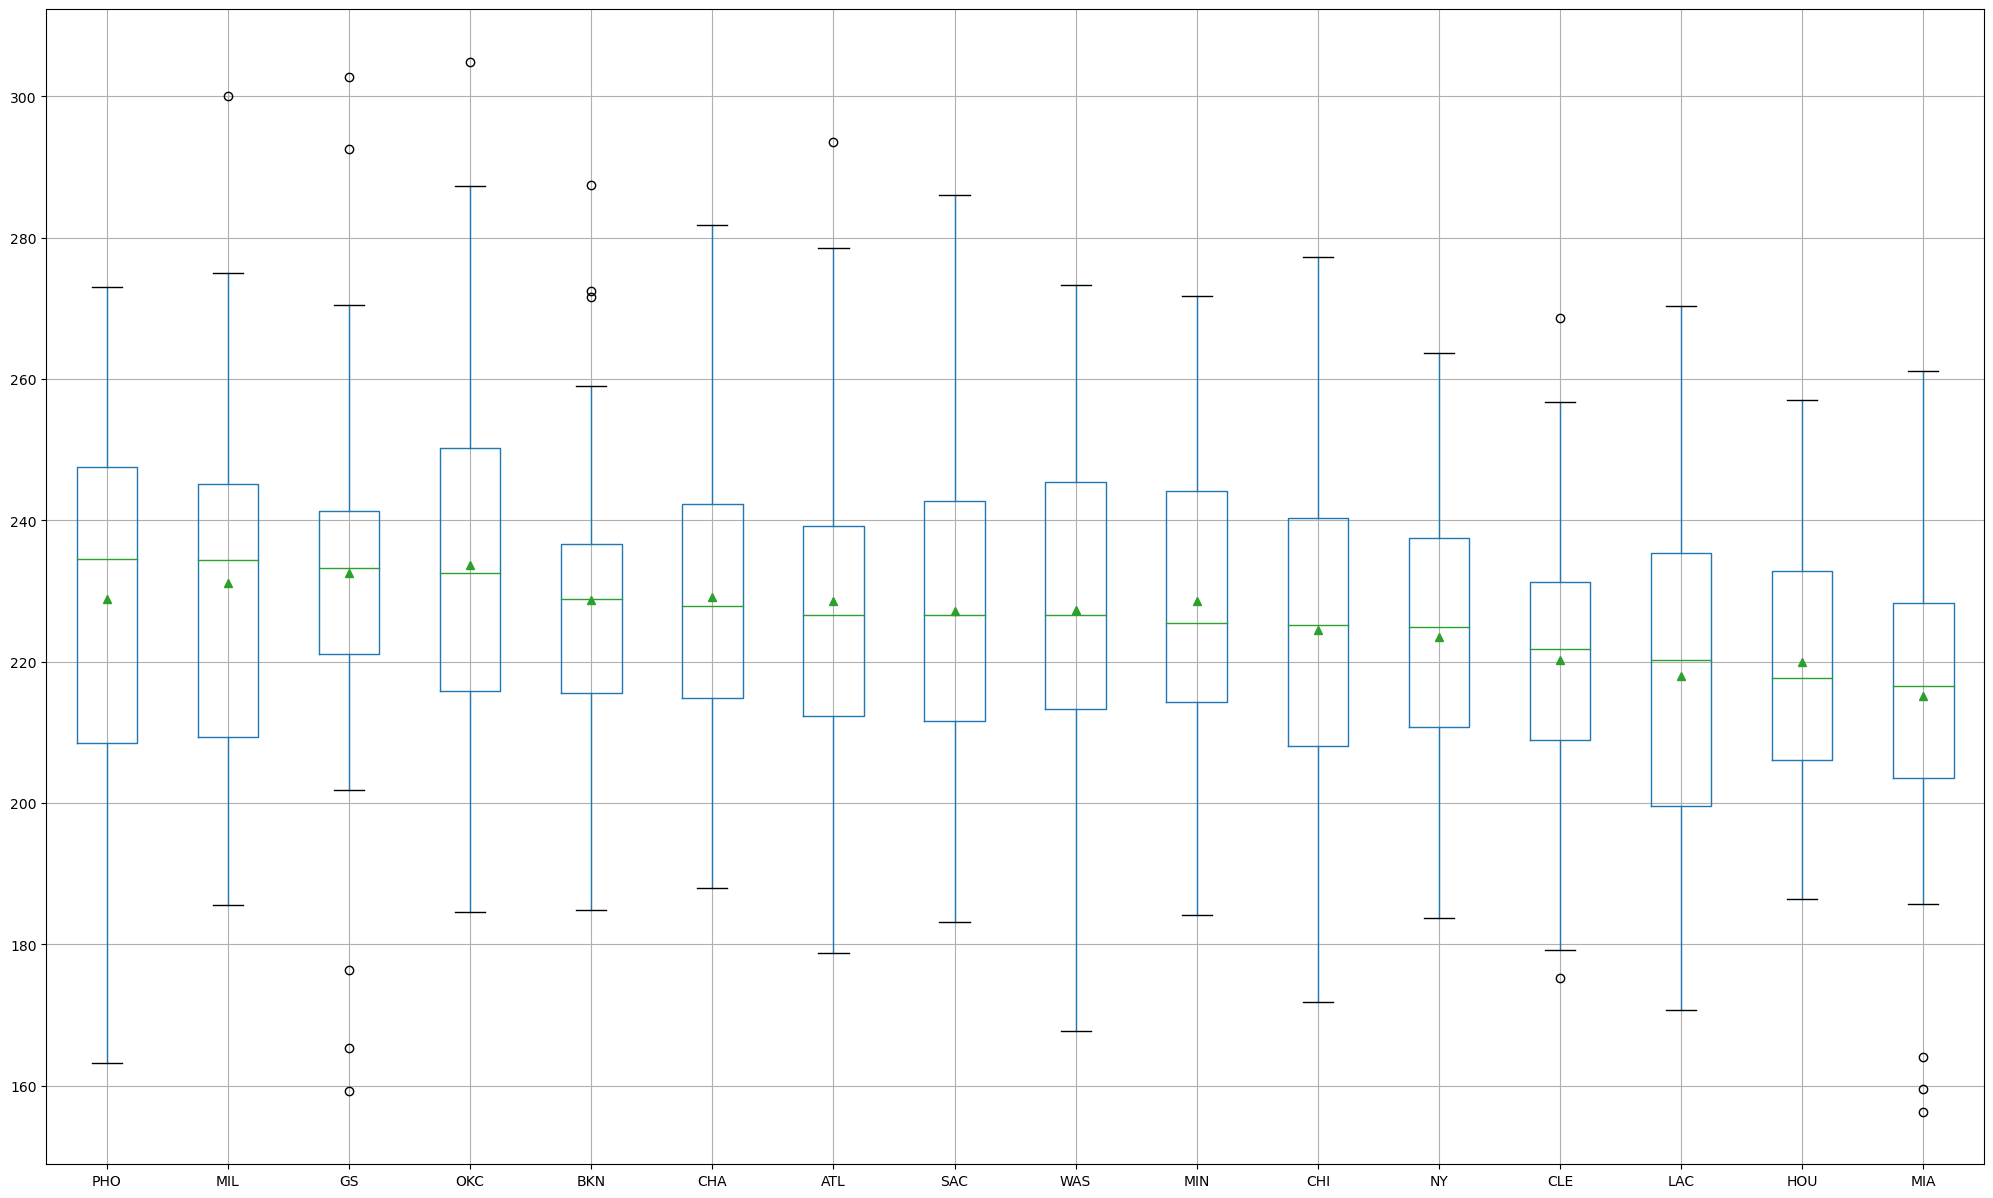

In [9]:
make_boxplots(
    teams=current_teams
);

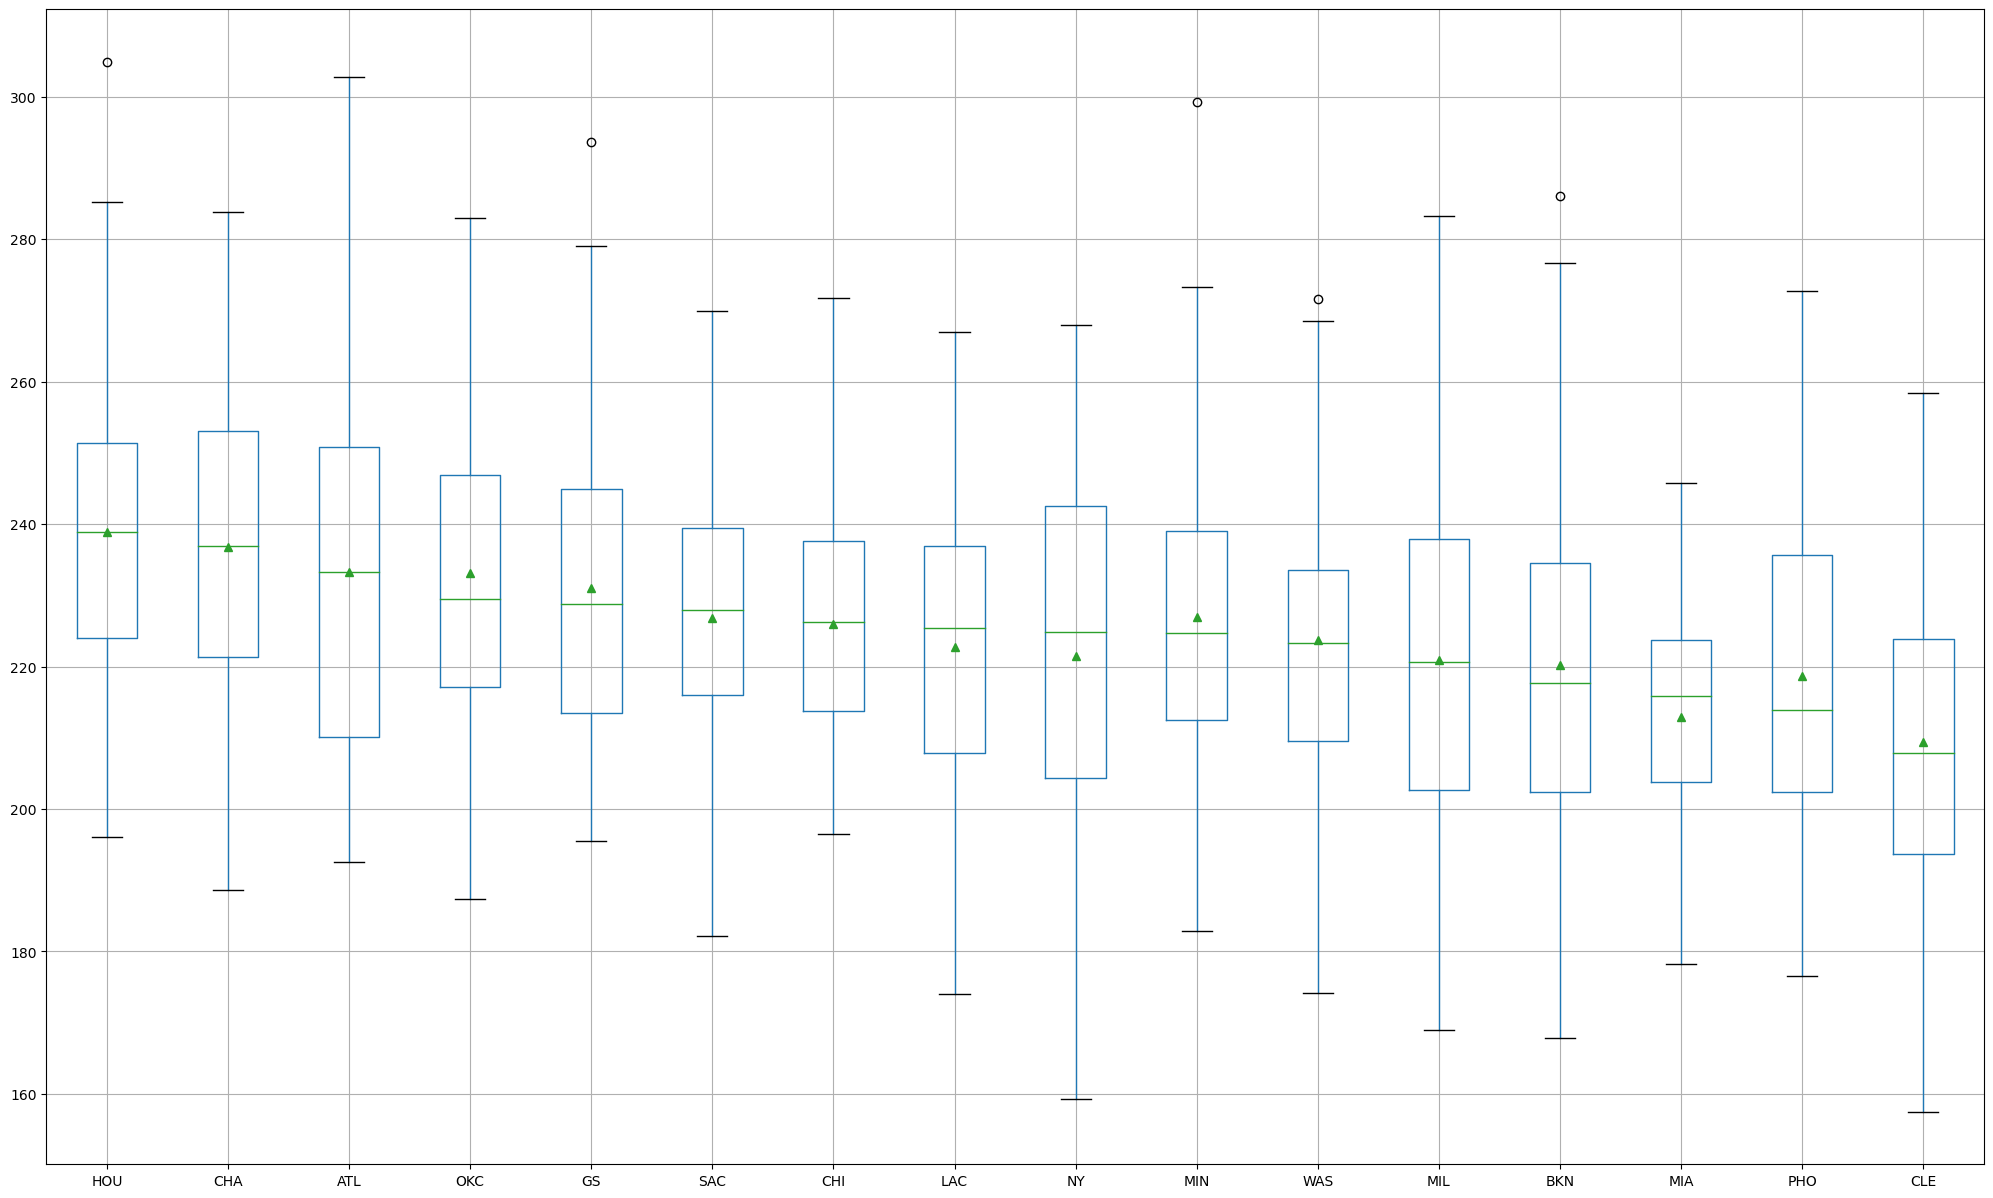

In [7]:
make_boxplots(
    teams=current_teams,
    team_col='opp',
);

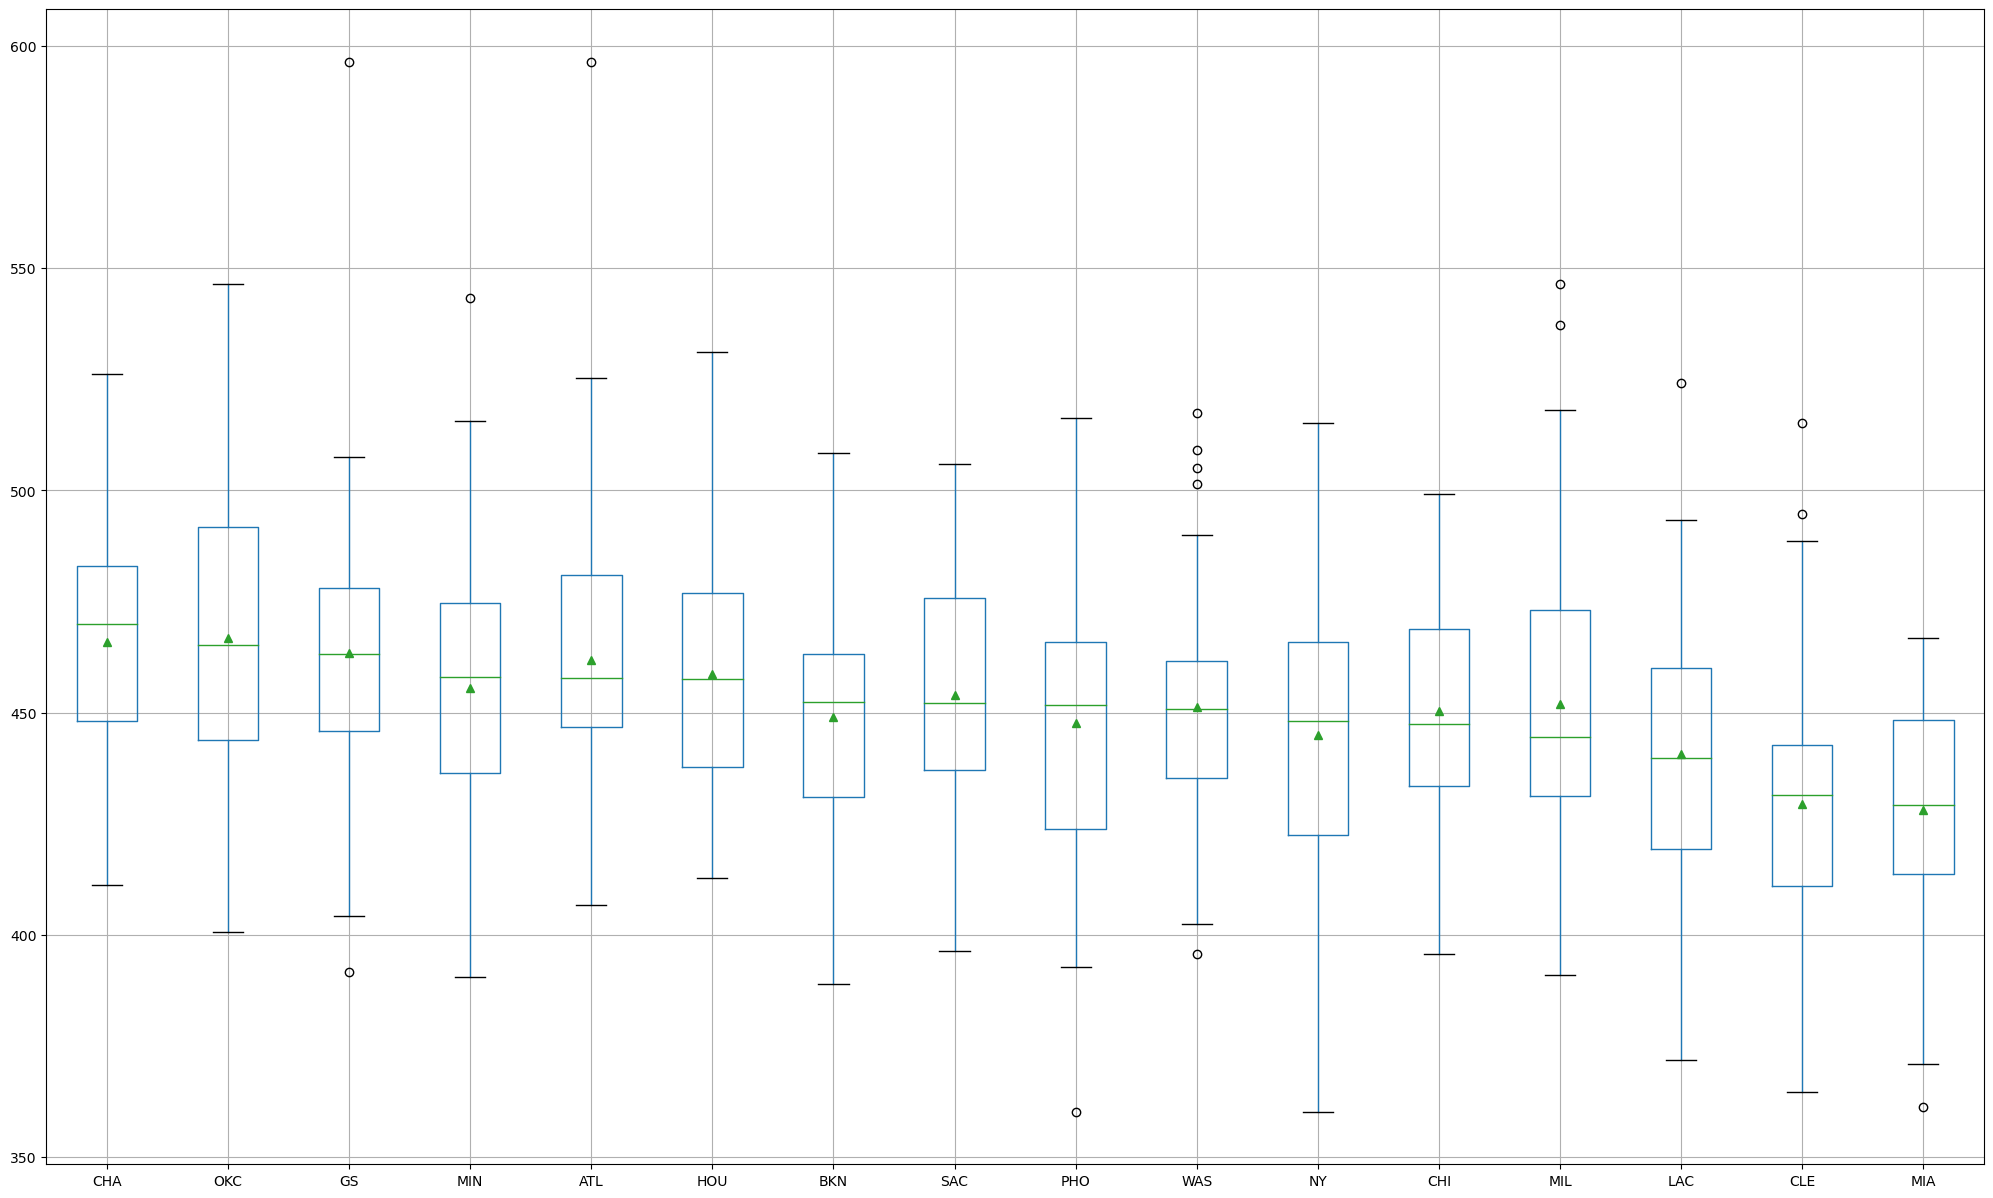

In [8]:
make_boxplots(
    teams=current_teams,
    fpts_col='mu_fpts'
);